In [188]:
import pandas as pd
import numpy as np
import sklearn as sklearn
import fnmatch
import os
import math
from scipy import ndimage
#from reskit.core import Pipeliner

from matplotlib import offsetbox
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

In [189]:
import warnings
warnings.simplefilter("ignore")

In [272]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.utils import check_random_state
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import (manifold, ensemble, discriminant_analysis, random_projection, preprocessing)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, RepeatedStratifiedKFold
from sklearn.manifold import LocallyLinearEmbedding, SpectralEmbedding, MDS, TSNE
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel,SelectKBest,chi2, f_classif

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA, NMF

# Данные:

* thickness_mri_lh + thickness_mri_rh
* volumes_mri_freesurfer
* conn_data (RESULTS_C_D_E_DE_KONDRATEVA_10.12)
* all datasets + clinical data


In [229]:
#thickness
thickness_mri_lh = pd.read_csv('data/mp_rage_data/th_lh_mp_rage.csv').sort_values(['Unnamed: 0']).set_index(['Unnamed: 0']).join(pd.read_csv('data/th_lh_last.csv').set_index(['index'])['target'])

#.drop(labels=['Unnamed: 0'], axis=1, inplace=False)
#.drop(labels=['index','target'], axis=1, inplace=False)
thickness_mri_rh = pd.read_csv('data/mp_rage_data/th_rh_mp_rage.csv').sort_values(['Unnamed: 0']).set_index(['Unnamed: 0'])
thickness_mri = pd.concat([thickness_mri_lh, thickness_mri_rh], axis = 1)

#volumes
volumes_mri_freesurfer = pd.read_csv('data/mp_rage_data/volumes_mri_mp_rage.csv').sort_values(['Unnamed: 0']).set_index(['Unnamed: 0'])

#fMRI
#conn_data = pd.read_csv('data/RESULTS_C_D_E_DE_KONDRATEVA_10.12.csv', sep = ';').drop(labels = ['index'], axis=1, inplace=False)
#conn_data = conn_data.fillna(0)

#Clinical data
dem_data = pd.read_csv('data/table_10102017_new.csv', sep=';', encoding = 'UTF-8').sort_values(['patient']).set_index('patient')



In [260]:
BDI = dem_data.join(thickness_mri['target'], how = 'inner')['BDI']

Data for 4 class classification

In [233]:
target = thickness_mri['target']

thickness = thickness_mri.drop(labels=['target'], axis=1)
#.reset_index(drop = True)
volumes = volumes_mri_freesurfer
#.reset_index(drop = True)


#conn = conn_data.drop(labels=['target'], axis=1)

# Добавляем демографию (только то, что есть для всех 4 групп пациентов)
common_dem = dem_data[dem_data.columns[[1,2,4,5]]]

###### объединить два датасета, когда появятся данные ####
#all_data_conn = pd.concat([conn, common_dem.reset_index()], axis = 1).drop(labels=['\ufeffpatient'], axis=1)
full_mri = pd.concat([thickness, volumes], axis = 1)
mri_dem = full_mri.join(common_dem)
#all_data_mri = 
#full_dataset = pd.concat([thickness.reset_index(), volumes.reset_index(), conn.reset_index()], axis = 1).drop(labels = ['index'], axis = 1)

In [236]:
target.value_counts()
#conn_target.value_counts()

D     24
С     23
DE    22
E     21
Name: target, dtype: int64

In [237]:
data = [thickness, volumes, full_mri, mri_dem]
        #, all_data_conn, all_data_mri]
data_names = ['thickness_mri_freesurfer', 'volumes_mri_freesurfer', 'thickness+volumes','MRI + dem']



In [238]:
le = preprocessing.LabelEncoder()
le.fit(target)
y = le.transform(target)

#0 - D, 1 - DE, 2 - E, 3 - C

Epilepsy (50) vs no Epilepsy (50)

In [84]:
# Datasets are the same, only target change

In [85]:
### Try (additionaly) to add depression length

In [240]:
y_e = list(map(lambda x: 1 if 'E' in x else 0, target))

Depression (50) vs no Depression (50)

In [87]:
# Datasets are the same, only target change
### Try (additionaly) to add epilepsy stat


# #Only demographics change
# # Add epileptic data
# dem_D = dem_data.drop(labels=['patient','target','length'], axis = 1).fillna(0)


# all_data_D = pd.concat([dem_D, conn], axis=1)

In [241]:
y_d = list(map(lambda x: 1 if 'D' in x else 0, target))

Epilepsy (25) vs Control (25)

In [242]:
thickness_EC = thickness_mri.loc[(thickness_mri['target'] == 'С')| (thickness_mri['target'] == 'E'), :]
volumes_EC = volumes_mri_freesurfer[volumes_mri_freesurfer.index.map(lambda x: x in thickness_EC.index)]
#.reset_index(drop = True)
conn_EC = conn_data.loc[(conn_data['target'] == 'С')|(conn_data['target'] == 'E'),:]

target_EC = thickness_EC['target']

thickness_EC = thickness_EC.drop(labels=['target'], axis=1).reset_index(drop = True)
conn_EC = conn_EC.drop(labels=['target'], axis=1).reset_index(drop =True)

# Добавляем демографию (только то, что есть для обеих групп)
#dem_EC = dem_data.loc[(dem_data['key'] == 'С')| (dem_data['key'] == 'E'), :][dem_data.columns[[1,2,4,5]]]

###### объединить два датасета, когда появятся данные ####

#full_dataset_EC = pd.concat([thickness_EC, volumes_EC, conn_EC], axis = 1)


full_mri = pd.concat([thickness_EC, volumes_EC], axis = 1)
mri_dem = full_mri.join(common_dem)

In [90]:
data_EC = [thickness_EC, volumes_EC, conn_EC, full_dataset_EC]
           #, all_data_conn_EC, all_data_mri_EC]

In [91]:
le.fit(target_EC)
y_EC = le.transform(target_EC)

#0 - E, 1 - C

Depression (25) vs Control (25)

In [92]:
thickness_DC = thickness_mri.loc[(thickness_mri['target'] == 'С')| (thickness_mri['target'] == 'D'), :]
volumes_DC = volumes_mri_freesurfer[volumes_mri_freesurfer.index.map(lambda x: x in thickness_DC.index)].reset_index(drop = True)
conn_DC = conn_data.loc[(conn_data['target'] == 'С')|(conn_data['target'] == 'D'),:]

target_DC = thickness_DC['target']

thickness_DC = thickness_DC.drop(labels=['target'], axis=1).reset_index(drop = True)
conn_DC = conn_DC.drop(labels=['target'], axis=1).reset_index(drop = True)

# Добавляем демографию (только то, что есть для обеих групп)
#dem_DC = dem_data.loc[(dem_data['target'] == 'С')| (dem_data['target'] == 'D'), :][dem_data.columns[[1,2,4,5]]]


###### объединить два датасета, когда появятся данные ####
#all_data_conn_DC = pd.concat([conn_DC.reset_index(), dem_DC.reset_index()], axis = 1).drop(labels=['patient'], axis=1)
#all_data_mri_DC = pd.concat([thickness_DC, volumes_DC], axis = 1)
#all_data_mri_DC = all_data_mri_DC.join(dem_DC)
full_dataset_DC = pd.concat([thickness_DC, volumes_DC, conn_DC], axis = 1)
#.drop(labels=['index'], axis=1)

In [93]:
data_DC = [thickness_DC, volumes_DC, conn_DC, full_dataset_DC]
#, all_data_conn_DC, all_data_mri_DC]

In [94]:
le.fit(target_DC)
y_DC = le.transform(target_DC)
#0 - D, 1 - C

In [95]:
y_DC

array([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

Depression with epilepsy (25) vs Epilepsy (25)

In [96]:
thickness_DEE = thickness_mri.loc[(thickness_mri['target'] == 'DE')| (thickness_mri['target'] == 'E'), :]
volumes_DEE = volumes_mri_freesurfer[volumes_mri_freesurfer.index.map(lambda x: x in thickness_DEE.index)].reset_index(drop = True)
conn_DEE = conn_data.loc[(conn_data['target'] == 'DE')|(conn_data['target'] == 'E'),:]

target_DEE = thickness_DEE['target']
conn_target_DEE = conn_DEE['target']

thickness_DEE = thickness_DEE.drop(labels=['target'], axis=1).reset_index(drop = True)
conn_DEE = conn_DEE.drop(labels=['target'], axis=1).reset_index(drop = True)

# Добавляем демографию (только то, что есть для всех обеих групп пациентов)
# тут добавляются данные по эпилепсии
#dem_DEE = dem_data.loc[(dem_data['target'] == 'DE')| (dem_data['target'] == 'E'), :].drop(labels=['target','length'], axis = 1).fillna(0)

###### объединить два датасета, когда появятся данные ####
#all_data_conn_DEE = pd.concat([conn_DEE.reset_index(), dem_DEE.reset_index()], axis = 1).drop(labels=['patient','index'], axis=1)
#all_data_mri_DEE = pd.concat([thickness_DEE, volumes_DEE], axis = 1)
#all_data_mri_DEE = all_data_mri_DEE.join(dem_DEE)
full_dataset_DEE = pd.concat([thickness_DEE, volumes_DEE, conn_DEE], axis = 1)

In [97]:
data_DEE = [thickness_DEE, volumes_DEE, conn_DEE,full_dataset_DEE]
#, all_data_conn_DEE, all_data_mri_DEE]

In [98]:
le.fit(target_DEE)
y_DEE = le.transform(target_DEE)

#1 - E, 0 - DE

In [99]:
y_DEE

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0])

#### отбор признаков на основе модели
аналогично SelectFromModel, но на основе количества признаков, а не порога

In [243]:

from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone
from sklearn.feature_selection.base import SelectorMixin
from sklearn.feature_selection.from_model import _get_feature_importances
from sklearn.utils.metaestimators import if_delegate_has_method

class SelectNFeaturesFromModel(BaseEstimator, SelectorMixin, MetaEstimatorMixin):
    def __init__(self, estimator, n_selected, prefit=False):
        self.estimator = estimator
        self.n_selected = n_selected
        self.prefit = prefit

    def _get_support_mask(self):
        if self.prefit:
            estimator = self.estimator
        elif hasattr(self, 'estimator_'):
            estimator = self.estimator_
        else:
            raise ValueError(
                'Either fit SelectFromModel before transform or set "prefit='
                'True" and pass a fitted estimator to the constructor.')
        scores = _get_feature_importances(estimator)
        threshold = np.sort(scores)[-self.n_selected]
        return scores >= threshold

    def fit(self, X, y=None, **fit_params):
        if self.prefit:
            raise NotFittedError(
                "Since 'prefit=True', call transform directly")
        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(X, y, **fit_params)
        return self

    @property
    def threshold_(self):
        scores = _get_feature_importances(self.estimator_, self.norm_order)
        return np.sort(scores)[-n_selected]
    
    @if_delegate_has_method('estimator')
    def partial_fit(self, X, y=None, **fit_params):
        if self.prefit:
            raise NotFittedError(
                "Since 'prefit=True', call transform directly")
        if not hasattr(self, "estimator_"):
            self.estimator_ = clone(self.estimator)
        self.estimator_.partial_fit(X, y, **fit_params)
        return self

### Pipieline for Logistic regression

In [280]:
def find_best_lr(X, y, N_components = np.array([1, 2, 3, 5, 10, 15, 20]), N_features = np.array([5,10,20,50,100])):
        
    # Stratification
    skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=2,  random_state=42)
   


    # Feture selection + kNN pipline
    pipe = Pipeline([
        ('preprocessing', PCA()),
        ('classify', LogisticRegression(solver = 'saga'))
    ])
    

    # Parameters for grid search

    # penalty
    penalty = np.array(['l1', 'l2'])
    
    #regularization parameter
    C_OPTIONS = np.array([0.1, 1.0]) 

    #‘ovr’ --- a binary problem is fit for each label
    # ‘multinomial’ --- loss minimised is the multinomial loss fit across the entire probability distribution
    multi_class = np.array(['multinomial', 'ovr'])
    
    
    #SelectFromModel - default
    param_grid = [
        {
            'preprocessing': [PCA( ), 
                               discriminant_analysis.LinearDiscriminantAnalysis( ),
                               LocallyLinearEmbedding()],
            'preprocessing__n_components': N_components,
            'classify__penalty': penalty,
            'classify__C': C_OPTIONS,
            'classify__multi_class':multi_class
        },{
            'preprocessing': [SelectNFeaturesFromModel(ExtraTreesClassifier(), n_selected = 10)],
            'preprocessing__estimator': [ExtraTreesClassifier(), LogisticRegression()],
            'preprocessing__n_selected': N_features,
            'classify__penalty': penalty,
            'classify__C': C_OPTIONS,
            'classify__multi_class':multi_class
        }, {
            'preprocessing': [SelectKBest(chi2), SelectKBest(f_classif)],
            'preprocessing__k': N_features, 
            'classify__penalty': penalty,
            'classify__C': C_OPTIONS,
            'classify__multi_class':multi_class
        },{
            'preprocessing': [None],
            'classify__penalty': penalty,
            'classify__C': C_OPTIONS,
            'classify__multi_class':multi_class
        }
    ]
    

    grid = GridSearchCV(pipe, cv=skf, n_jobs=1, param_grid=param_grid)
    grid.fit(X, y)

    
    mean_scores = np.array(grid.cv_results_['mean_test_score'])
    ind = grid.best_index_
    

    print()
    print('Best score:', mean_scores[ind])
    print('Std:', grid.cv_results_['std_test_score'][ind])
    print('Penalty:', grid.cv_results_['params'][ind]['classify__penalty'])
    print('C = ', grid.cv_results_['params'][ind]['classify__C'])
    print('multi_class:', grid.cv_results_['params'][ind]['classify__multi_class'])
    print()
    print('Preprocessing:', grid.cv_results_['params'][ind]['preprocessing'])
    print()
    print()
    return {"best score": grid.best_score_, "std":grid.cv_results_['std_test_score'][ind], 
            "lr_param":{'penaltys':grid.best_params_['classify__penalty'], 
                         'C':grid.best_params_['classify__C'],
                         'multi_class':grid.best_params_['classify__multi_class']}, 
            'prep_method':grid.best_params_['preprocessing']}
    

### Pipeline for kNN

In [281]:
def find_best_knn(X, y, N_components = np.array([1, 2, 3, 5, 10, 15, 20]), N_features = np.array([5,10,20,50,100])):
        
    # Stratification
    skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=2,  random_state=42)
   


    # Feture selection + kNN pipline
    pipe = Pipeline([
         ('preprocessing', PCA( )),
        ('classify', KNeighborsClassifier())
    ])

    # Parameters for grid search
    
    # 1 to k neighbours (with step 5)
    C_OPTIONS = np.array([1, 2, 3, 5, 10, 15, 20])
    
    #'uniform' --- all neighbours have the same weight 
    #'distance' --- weights are proportional to the inverse of the distance from the query point
    W_OPTIONS = np.array(['uniform', 'distance']) 

    # Parameter for the Minkowski metric
    # p = 1 --- manhattan_distance (L1) 
    # p = 2 --- euclidean_distance (L2) 
    p_OPTIONS = np.array([1, 2, 4])
    
    #SelectFromModel - default
    param_grid = [
        {
            'preprocessing': [PCA( ), 
                               discriminant_analysis.LinearDiscriminantAnalysis( ),
                               LocallyLinearEmbedding()],
            'preprocessing__n_components': N_components,
            'classify__n_neighbors': C_OPTIONS,
            'classify__weights': W_OPTIONS,
            'classify__p':p_OPTIONS
        },{
            'preprocessing': [SelectNFeaturesFromModel(estimator = ExtraTreesClassifier(), n_selected = 10)],
            'preprocessing__estimator': [ExtraTreesClassifier(), LogisticRegression()],
            'preprocessing__n_selected': N_features,
            'classify__n_neighbors': C_OPTIONS,
            'classify__weights': W_OPTIONS,
            'classify__p':p_OPTIONS
        }, {
            'preprocessing': [SelectKBest(chi2), SelectKBest(f_classif)],
            'preprocessing__k': N_features, 
            'classify__n_neighbors': C_OPTIONS,
            'classify__weights': W_OPTIONS,
            'classify__p':p_OPTIONS
        },{
            'preprocessing': [None],
            'classify__n_neighbors': C_OPTIONS,
            'classify__weights': W_OPTIONS,
            'classify__p':p_OPTIONS
        }
    ]
    

    grid = GridSearchCV(pipe, cv=skf, n_jobs=1, param_grid=param_grid)
    grid.fit(X, y)

    
    mean_scores = np.array(grid.cv_results_['mean_test_score'])
    ind = grid.best_index_
    

    print()
    print('Best score:', mean_scores[ind])
    print('Std:', grid.cv_results_['std_test_score'][ind])
    print('Number of neighbours:', grid.cv_results_['params'][ind]['classify__n_neighbors'])
    print('Weightning scheme:', grid.cv_results_['params'][ind]['classify__weights'])
    print('p = ', grid.cv_results_['params'][ind]['classify__p'])
    print()
    print('Preprocessing:', grid.cv_results_['params'][ind]['preprocessing'])
    print()
    print()
    return {"best score": grid.best_score_, "std":grid.cv_results_['std_test_score'][ind], 
            "knn_param":{'n_neighbors':grid.best_params_['classify__n_neighbors'], 
                         'p':grid.best_params_['classify__p'],
                         'weights':grid.best_params_['classify__weights']}, 
            'prep_method':grid.best_params_['preprocessing']}
    

### Pipeline for Random forest

In [282]:
def find_best_rfc(X, y, N_components = np.array([1, 2, 3, 5, 10, 15, 20]), N_features = np.array([5,10,20,50,100])):
        
    # Stratification
    skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=2,  random_state=42)
   


    # Feture selection + kNN pipline
    pipe = Pipeline([
        ('preprocessing', PCA( )),
        ('classify', RandomForestClassifier())
        ])

    # Parameters grid search

    
    # number of trees
    C_OPTIONS = np.array([1, 10, 50, 100])
        
    #criterion for splitting
    criterion = np.array(['gini', 'entropy']) 

    min_samples_leaf = np.array([1, 2, 4])
    
    #SelectFromModel - default
    param_grid = [
        {
            'preprocessing': [PCA( ), 
                               discriminant_analysis.LinearDiscriminantAnalysis( ),
                               LocallyLinearEmbedding()],
            'preprocessing__n_components': N_components,
            'classify__n_estimators': C_OPTIONS,
            'classify__criterion': criterion,
            'classify__min_samples_leaf':min_samples_leaf
        },{
            'preprocessing': [SelectNFeaturesFromModel(estimator = ExtraTreesClassifier(), n_selected = 10)],
            'preprocessing__estimator': [ExtraTreesClassifier(), LogisticRegression()],
            'preprocessing__n_selected': N_features,
            'classify__n_estimators': C_OPTIONS,
            'classify__criterion': criterion,
            'classify__min_samples_leaf':min_samples_leaf
        }, {
            'preprocessing': [SelectKBest(chi2), SelectKBest(f_classif)],
            'preprocessing__k': N_features,
            'classify__n_estimators': C_OPTIONS,
            'classify__criterion': criterion,
            'classify__min_samples_leaf':min_samples_leaf
        },{
             'preprocessing': [None],
             'classify__n_estimators': C_OPTIONS,
             'classify__criterion': criterion,
             'classify__min_samples_leaf':min_samples_leaf
         }
    ]
    

    grid = GridSearchCV(pipe, cv=skf, n_jobs=1, param_grid=param_grid)
    grid.fit(X, y)

    
    mean_scores = np.array(grid.cv_results_['mean_test_score'])
    ind = grid.best_index_
    

    print()
    print('Best score:', mean_scores[ind])
    print('Std:', grid.cv_results_['std_test_score'][ind])
    print('Number of trees:', grid.cv_results_['params'][ind]['classify__n_estimators'])
    print('Splitting criterion:', grid.cv_results_['params'][ind]['classify__criterion'])
    print('Min number of samples in the leaf:', grid.cv_results_['params'][ind]['classify__min_samples_leaf'])
    print()
    print('Preprocessing:', grid.cv_results_['params'][ind]['preprocessing'])
    print()
    print()
    return {"best score": grid.best_score_, "std":grid.cv_results_['std_test_score'][ind], 
            "rfc_param":{'n_estimators':grid.best_params_['classify__n_estimators'], 
                         'criterion':grid.best_params_['classify__criterion'],
                         'min_samples_leaf':grid.best_params_['classify__min_samples_leaf']}, 
            'prep_method':grid.best_params_['preprocessing']}
    

### Pipeline for SVD

In [289]:
def find_best_svc(X, y, N_components = np.array([1, 2, 3, 5, 10, 15, 20]), N_features = np.array([5,10,20,50,100])):
        
    # Stratification
    skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=2,  random_state=42)
   


    # Feture selection + kNN pipline
    pipe = Pipeline([
        ('preprocessing', PCA( )),
        ('classify', LinearSVC(dual=False))
        ])

    # Parameters for grid search
    
    # penalty parameter
    C_OPTIONS = np.array([0.001, 0.1, 1, 10])
    penalty = ['l1', 'l2']
        
    # kernel
    #kernel = ['rbf', 'linear', 'poly', 'sigmoid']
    # gamma parameter
    #gamma = np.array([0.001, 1, 2, 4])
    #gamma = np.array([1])
    # degree
    #degree = np.array([1,2,3,4])
    #degree = np.array([1])
    
    #SelectFromModel - default
    param_grid = [
        {
            'preprocessing': [PCA( ), 
                               discriminant_analysis.LinearDiscriminantAnalysis( ),
                               LocallyLinearEmbedding()],
            'preprocessing__n_components': N_components,
            'classify__C': C_OPTIONS,
            'classify__penalty':penalty
           # 'classify__kernel': kernel,
           # 'classify__gamma':gamma,
           # 'classify__degree': degree
        },{
            'preprocessing': [SelectNFeaturesFromModel(estimator = ExtraTreesClassifier(), n_selected = 10)],
            'preprocessing__estimator': [ExtraTreesClassifier(), LogisticRegression()],
            'preprocessing__n_selected': N_features,
            'classify__C': C_OPTIONS,
            'classify__penalty':penalty
           # 'classify__kernel': kernel,
           # 'classify__gamma':gamma,
           # 'classify__degree': degree
        }, {
            'preprocessing': [SelectKBest(chi2), SelectKBest(f_classif)],
            'preprocessing__k': N_features,
            'classify__C': C_OPTIONS,
            'classify__penalty':penalty
           # 'classify__kernel': kernel,
           # 'classify__gamma':gamma,
           # 'classify__degree': degree
        },{
             'preprocessing': [None],
             'classify__C': C_OPTIONS,
            'classify__penalty':penalty
          #   'classify__kernel': kernel,
          #   'classify__gamma':gamma,
          #   'classify__degree': degree
         }
    ]
    

    grid = GridSearchCV(pipe, cv=skf, n_jobs=1, param_grid=param_grid)
    grid.fit(X, y)

    
    mean_scores = np.array(grid.cv_results_['mean_test_score'])
    ind = grid.best_index_
    

    print()
    print('Best score:', mean_scores[ind])
    print('Std:', grid.cv_results_['std_test_score'][ind])
    print('Regulsrization parameter:', grid.cv_results_['params'][ind]['classify__C'])
    print('Penalty:', grid.cv_results_['params'][ind]['classify__penalty'])
    #print('Kernel:', grid.cv_results_['params'][ind]['classify__kernel'])
    #print('Gamma:', grid.cv_results_['params'][ind]['classify__gamma'])
    #print('Degree:', grid.cv_results_['params'][ind]['classify__degree'])
    print()
    print('Preprocessing:', grid.cv_results_['params'][ind]['preprocessing'])
    print()
    print()
    return {"best score": grid.best_score_, "std":grid.cv_results_['std_test_score'][ind], 
            "svc_param":{'C':grid.best_params_['classify__C'], 
                         'penalty':grid.best_params_['classify__penalty'],
                        # 'gamma':grid.best_params_['classify__gamma'],
                        #'degree':grid.best_params_['classify__degree']
                        }, 
            'prep_method':grid.best_params_['preprocessing']}
    

In [247]:
def draw_mean_std(results, data, y):
    
    '''
    results - dictionary, contaning best model for each dataset:
            best score
            std
            knn_param - dictionary with parameters, passed to kNN
            prep_method - method for data preprocessing (if applicable)
    
    data - list of dataset
    y - target variable
    '''
    names = ['Volumes','Thicknesses', 'fMRI', 'Full dataset']
    perf =  [[] for _ in range(len(data))]
    best_features =  [[] for _ in range(len(data))]


    for iter in [42,0,60,72,76,82,7,9,765,654,1,54,634,8,35,85,43,2345,87,99]:
    
        sss = StratifiedShuffleSplit(n_splits=10, test_size=20,  random_state=iter)
        #sss.get_n_splits(X, y_t)

        for dataset in range(len(data)):
            scores = np.array([results[0][dataset]['best score'], 
                          results[1][dataset]['best score'], 
                          results[2][dataset]['best score']])

            model_index = np.where(scores == max(scores))[0][0]
            best_knn_args = results[model_index][dataset]['knn_param']
            model =  KNeighborsClassifier(**best_knn_args)

            for train_index, test_index in sss.split(data[0], y):
            
                if (results[model_index][dataset]['prep_method'] == ''):
                    # fit
                    model.fit(data[dataset].iloc[train_index],y[train_index])
                        
                    # test
                    model_s = model.score(data[dataset].iloc[test_index],y[test_index])
                    perf[dataset].append(model_s)
                
                elif (str(results[model_index][dataset]['prep_method']).find('Select') >= 0):
                    # transform
                    transformer = results[model_index][dataset]['prep_method']       
                    transformed_data = transformer.fit_transform(data[dataset].iloc[train_index], y[train_index])
                    mask = transformer.fit(data[dataset].iloc[train_index], y[train_index]).get_support(indices = True)
                    best_features[dataset].append(data[dataset].columns[mask])
                
                    # fit
                    model.fit(transformed_data,y[train_index])
                
                    # test
                    model_s = model.score(data[dataset].iloc[:, mask].iloc[test_index],y[test_index])
                    perf[dataset].append(model_s)
            
                else:
                    # transform
                    transformer = results[model_index][dataset]['prep_method']       
                    transformed_data = transformer.fit_transform(data[dataset].iloc[train_index], y[train_index])
                
                
                    # fit
                    model.fit(transformed_data,y[train_index])
                
                    # test
                    transformed_test_data = transformer.fit_transform(data[dataset].iloc[test_index])
                    model_s = model.score(transformed_test_data, y[test_index])
                    perf[dataset].append(model_s)


    data_perf={'Thicknesses':perf[0],'Volumes':perf[1],'fMRI':perf[2], 'Full dataset':perf[3]}
    #, 'fMRI with clinical data':perf3, 'MRI with clinical data':perf4}
    perf=pd.DataFrame(data_perf, columns=('Thicknesses','Volumes','fMRI', 'Full dataset'))
    #, 'fMRI with clinical data', 'MRI with clinical data'))


    print(np.mean(perf['Thicknesses']), np.mean(perf['Volumes']),np.mean(perf['fMRI']), np.mean(perf['Full dataset']))
      #,np.mean(perf['fMRI with clinical data']),np.mean(perf['MRI with clinical data']))
    print(np.std(perf['Thicknesses']), np.std(perf['Volumes']),np.std(perf['fMRI']), np.std(perf['Full dataset']))
      #,np.std(perf['fMRI with clinical data']),np.std(perf['MRI with clinical data']))
    perf=np.array(perf)

    plt.figure(figsize=[10,5])
    plt.violinplot(perf,positions=range(len(data)))
    plt.xticks(range(len(data)), names, fontsize=8)
    
    plt.axis(xmin = -0.5, xmax = dataset + 0.5, ymin=0, ymax=1.05)
    plt.ylabel('Accuracy',fontsize=8)
#    plt.title('4 classes, best models')
    plt.show()
    

# 4 types classification

* No dimensionality reduction or feature selection
* With dimensionality reduction:
    + PCA
    + LDA
    + LLE
* With feture selection
    + ExtraTreesClassifier
    + LogisticRegression
    + SelectKBest(chi2)
    + SelectKBest(f_classif)

#### Random forest on BDI only

In [261]:
clf = RandomForestClassifier()
ss = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,  random_state=42)
    
    
    # number of trees
C_OPTIONS = np.array([1, 10, 50, 100])
    
    #criterion for splitting
criterion = np.array(['gini', 'entropy']) 

min_samples_leaf = np.array([1, 2, 4])
    
    #SelectFromModel - default
param_grid = [
        {   'n_estimators': C_OPTIONS,
            'criterion': criterion,
            'min_samples_leaf':min_samples_leaf}]

grid = GridSearchCV(clf, param_grid = param_grid, cv=ss)
grid.fit(BDI.reshape(-1, 1), y)

ind = grid.best_index_
print()
print('Best score:', np.array(grid.cv_results_['mean_test_score'])[ind])
print('Std:', grid.cv_results_['std_test_score'][ind])
print('Number of trees:', grid.cv_results_['params'][ind]['n_estimators'])
print('Splitting criterion:', grid.cv_results_['params'][ind]['criterion'])
print('Min number of samples in the leaf:', grid.cv_results_['params'][ind]['min_samples_leaf'])


Best score: 0.466666666667
Std: 0.15304247043
Number of trees: 10
Splitting criterion: entropy
Min number of samples in the leaf: 4


#### Random forest on datasets

In [ ]:

for i in range(len(data)):

    print(data_names[i])
    print(' ')
    #find_best_rfc(data[i], y)
    #find_best_knn(data[i], y, N_components=[1], N_features=[10])
    #find_best_lr(data[i], y, N_components=[1], N_features=[10])
    #find_best_svc(data[i], y, N_components=[1], N_features=[10])
    print('------------------------------------')

### 4 classes

In [290]:
result_4classes = [[] for _ in range(4)]
N_components = [1, 2, 3, 5, 10, 15, 20]
N_features = [5,10,20,50,100]

for i in range(len(data)):

    print(data_names[i])
    print(' ')
    result_4classes[0].append(find_best_knn(data[i], y, N_components = N_components, N_features = N_features))
    print(' ')
    result_4classes[1].append(find_best_lr(data[i], y, N_components = N_components, N_features = N_features))
    print(' ')
    result_4classes[2].append(find_best_rfc(data[i], y, N_components = N_components, N_features = N_features))
    print(' ')
    result_4classes[3].append(find_best_svc(data[i], y, N_components = N_components, N_features = N_features))
    print('------------------------------------')

thickness_mri_freesurfer
 

Best score: 0.35
Std: 0.121381405358
Number of neighbours: 5
Weightning scheme: uniform
p =  4

Preprocessing: SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
             n_selected=10, prefit=False)


 

Best score: 0.405555555556
Std: 0.116978899169
Penalty: l2
C =  0.1
multi_class: ovr

Preprocessing: None


 

Best score: 0.394444444444
Std: 0.14544621539
Number of trees: 50
Splitting criterion: gini
Min number of samples in the leaf: 1

Preprocessing: PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)



In [ ]:
# result_4classes =  [[] for _ in range(3)]

# for i in range(len(data)):

#     print(data_names[i])
#     print(' ')
#     print('Classification on Raw Data')
#     result_4classes[0].append(grid_search_knn(data[i], y))
#     print('Classification with dimesionality reduction')
#     result_4classes[1].append(comparing_dim_reduction(data[i], y))
#     print('Classification with feature selection')
#     result_4classes[2].append(comparing_feature_selection(data[i], y))
#     print('------------------------------------')

#### Нарисуем среднее и стандартное отклонение по 10 кросс валидациям для лучшей модели каждого датасета


In [ ]:
draw_mean_std(result_4classes, data, y)

* Take best parameters for raw data
* Add feature selection \[1,10, 20, 30, 40\] 
* посмотреть, кто хуже всех предсазывается

# 2 classes

## Epilepsy (50) vs No epilepsy (50)

In [291]:
result_E =  [[] for _ in range(4)]


for i in range(len(data)):

    print(data_names[i])
    print(' ')
    result_E[0].append(find_best_knn(data[i], y_e, N_components = N_components, N_features = N_features))
    print(' ')
    result_E[1].append(find_best_lr(data[i], y_e, N_components = N_components, N_features = N_features))
    print(' ')
    result_E[2].append(find_best_rfc(data[i], y_e, N_components = N_components, N_features = N_features))
    print(' ')
    result_E[3].append(find_best_svc(data[i], y_e, N_components = N_components, N_features = N_features))
    print('------------------------------------')

thickness_mri_freesurfer
 

Best score: 0.644444444444
Std: 0.14016084235
Number of neighbours: 15
Weightning scheme: distance
p =  1

Preprocessing: SelectKBest(k=5, score_func=<function chi2 at 0x108aeac80>)


 

Best score: 0.661111111111
Std: 0.150359651141
Penalty: l1
C =  0.1
multi_class: multinomial

Preprocessing: None


 

Best score: 0.661111111111
Std: 0.114395890455
Number of trees: 50
Splitting criterion: gini
Min number of samples in the leaf: 1

Preprocessing: SelectKBest(k=5, score_func=<function chi2 at 0x108aeac80>)


 

Best score: 0.677777777778
Std: 0.170375402502
Regulsrization parameter: 0.001
Penalty: l2

Preprocessing: SelectKBest(k=100, score_func=<function chi2 at 0x108aeac80>)


------------------------------------
volumes_mri_freesurfer
 

Best score: 0.744444444444
Std: 0.117260393996
Number of neighbours: 15
Weightning scheme: uniform
p =  1

Preprocessing: LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage=None,
              solver='svd',

In [ ]:
draw_mean_std(result_E, data, y_E)

## Depression (50) vs No Depression (50)

In [292]:
result_D =  [[] for _ in range(4)]


for i in range(len(data)):

    print(data_names[i])
    print(' ')
    result_D[0].append(find_best_knn(data[i], y_d, N_components = N_components, N_features = N_features))
    print(' ')
    result_D[1].append(find_best_lr(data[i], y_d, N_components = N_components, N_features = N_features))
    print(' ')
    result_D[2].append(find_best_rfc(data[i], y_d, N_components = N_components, N_features = N_features))
    print(' ')
    result_D[3].append(find_best_svc(data[i], y_d, N_components = N_components, N_features = N_features))
    print('------------------------------------')

thickness_mri_freesurfer
 

Best score: 0.616666666667
Std: 0.188561808316
Number of neighbours: 10
Weightning scheme: uniform
p =  1

Preprocessing: PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)


 

Best score: 0.616666666667
Std: 0.186007433809
Penalty: l1
C =  0.1
multi_class: ovr

Preprocessing: SelectKBest(k=20, score_func=<function chi2 at 0x108aeac80>)


 

Best score: 0.633333333333
Std: 0.18530088978
Number of trees: 50
Splitting criterion: entropy
Min number of samples in the leaf: 2

Preprocessing: SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, ver

In [ ]:
draw_mean_std(result_D, data, y_D)

## Epilepsy (25) vs Control (25)

In [134]:
EC_results = [[] for _ in range(3)]

for i in range(len(data_EC)):
    print(data_names[i])
    print(' ')
    print('Classification on Raw Data')
    EC_results[0].append(grid_search_knn(data_EC[i], y_EC))
    print('Classification with dimesionality  reduction')
    EC_results[1].append(comparing_feature_reduction(data_EC[i], y_EC))
    print('Classification with feature selection')
    EC_results[2].append(comparing_feature_selection(data_EC[i], y_EC))
    print('------------------------------------')
    

In [ ]:
draw_mean_std(EC_results, data_EC, y_EC)

## Depression (25) vs Control (25)

In [164]:
DC_results = [[] for _ in range(3)]
for i in range(len(data_DC)):
    print(data_names[i])
    print(' ')
    print('Classification on Raw Data')
    DC_results[0].append(grid_search_knn(data_DC[i], y_DC, 25))
    print('Classification with dimesionality  reduction')
    DC_results[1].append(comparing_feature_reduction(data_DC[i], y_DC, 25))
    print('Classification with feature selection')
    DC_results[2].append(comparing_feature_selection(data_DC[i], y_DC, 25))
    print('------------------------------------')
    

0.64625 0.5655 0.50725 0.56075
0.0916429893663 0.0984111274196 0.107517149795 0.0935250634857


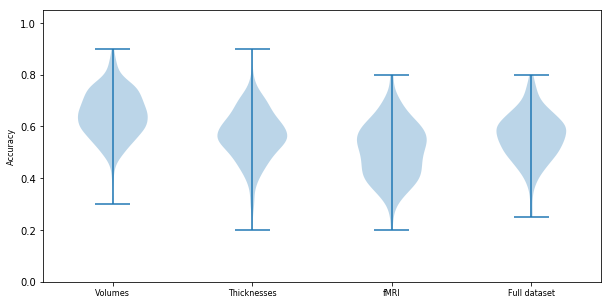

In [174]:
draw_mean_std(DC_results, data_DC, y_DC)

## Depression with epilepsy (25) vs Epilepsy (25)

In [ ]:
DEE_results = [[] for _ in range(3)]
for i in range(len(data_DEE)):
    print(data_names[i])
    print(' ')
    print('Classification on Raw Data')
    DEE_results[0].append(grid_search_knn(data_DEE[i], y_DEE))
    print('Classification with dimesionality reduction')
    DEE_results[1].append(comparing_feature_reduction(data_DEE[i], y_DEE))
    print('Classification with feature selection')
    DEE_results[2].append(comparing_feature_selection(data_DEE[i], y_DEE))
    print('------------------------------------')
    

In [ ]:
draw_mean_std(DC_results, data_DC, y_DC)

### Some Pictures :)

In [23]:
def calc_accuracy_for_data(data, methods, names_methods, par_grid, target):
    accuracy = []
    
    for i, method in enumerate(methods):
        accuracy.append([])
        for n_comp in par_grid:
            data_transformed = method.set_params(n_components=n_comp).fit_transform(data)

            knn_clf = KNeighborsClassifier()
            gs = GridSearchCV(estimator=knn_clf, cv=skf, scoring=make_scorer(accuracy_score), param_grid=param_grid)
            gs.fit(data_transformed, target)
            accuracy[-1].append(gs.best_score_)
            #print("method = " + names_methods[i] + " n_comp =  "+str(n_comp)+ "  score = ", str(gs.best_score_), "  std = ", gs.cv_results_['std_test_score'][gs.best_index_])
    
    return accuracy

In [24]:
def plot_accuracy(accuracy, title, names, par_grid):    
    N = len(n_comp_grid)

    ind = np.arange(N)  # the x locations for the groups
    width = 0.15       # the width of the bars
    fig, ax = plt.subplots(figsize=(8, 6))
    rects = []
    for i in range(len(methods)):
        rects.append(ax.bar(ind + width*i, accuracy[i], width, label=names[i]))
    ax.set_ylabel('Accuracy score')
    ax.set_xlabel("num components")

    ax.set_xticks(ind + width * 2)
    ax.set_xticklabels(par_grid)
    ax.set_ylim(0, 0.7)
    
    ax.set_title(title)

    ax.legend(loc=4)

### Бинарная классификация: есть депрессия/нет:

0
Best score: 0.636363636364
Std: 0.0832950631438
Number of neighbours: 14
Dimentioanlity reduction: PCA(copy=True, iterated_power='auto', n_components=17, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
1
Best score: 0.616161616162
Std: 0.0949172522088
Number of neighbours: 10
Dimentioanlity reduction: PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
2
Best score: 0.616161616162
Std: 0.1593592414
Number of neighbours: 58
Dimentioanlity reduction: PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
3
Best score: 0.616161616162
Std: 0.1593592414
Number of neighbours: 58
Dimentioanlity reduction: PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
4
Best score: 0.636363636364
Std: 0.17272431919
Number of neighbours: 30
Dimentioanlity reduction: PCA(copy=True, iterated_power='aut

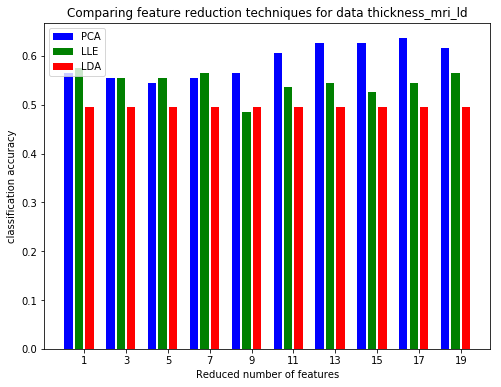

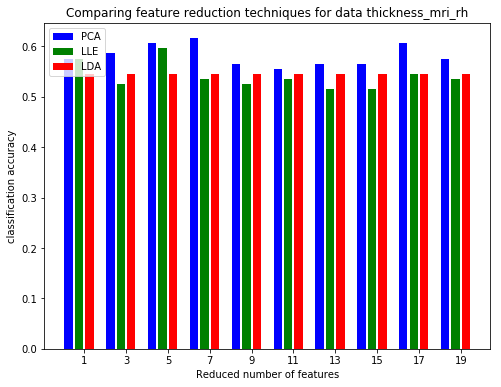

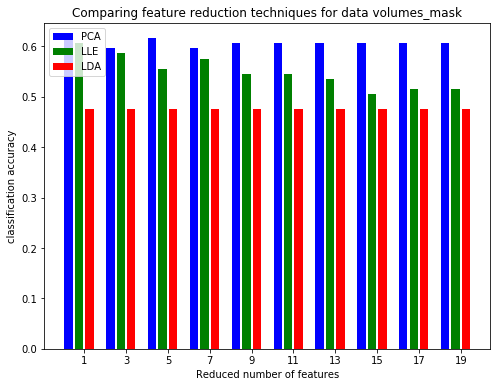

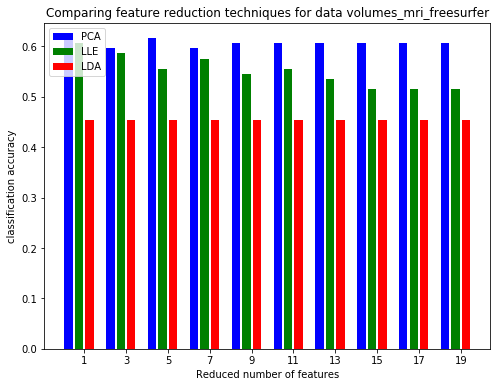

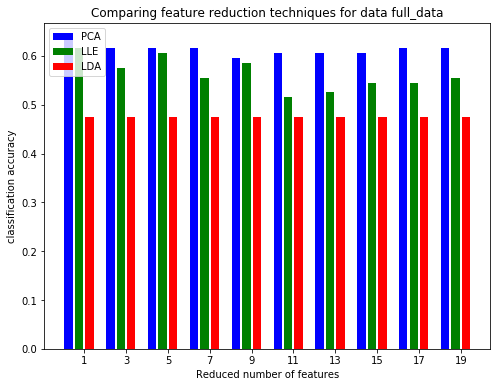

In [20]:
for i in range(len(data)):
    comparing_feature_reduction(data[i], data_names[i], target_depression)
        print()

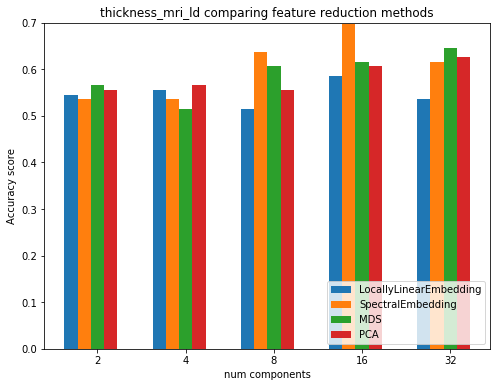

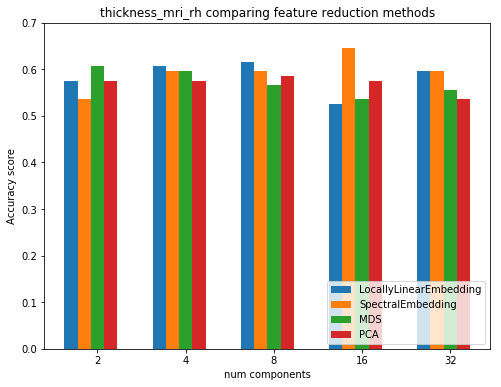

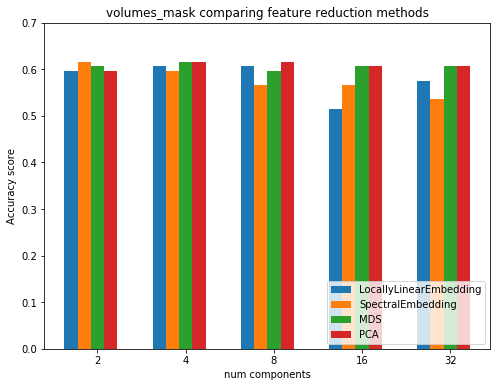

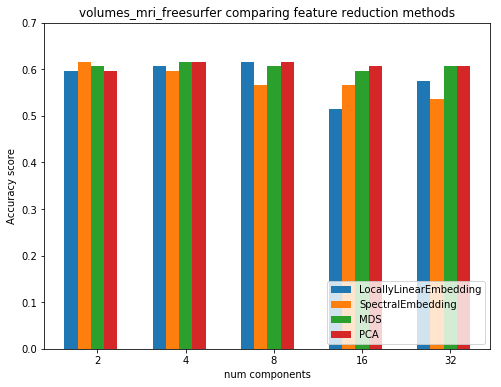

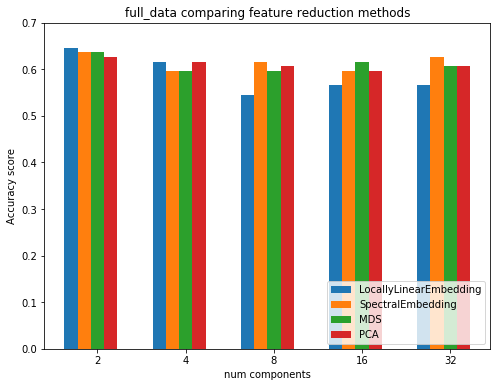

In [26]:
for i, d in enumerate(data):
    accuracy = calc_accuracy_for_data(d, methods, names_methods, n_comp_grid, target_depression)

    plot_accuracy(accuracy, data_names[i] + " comparing feature reduction methods", names_methods, n_comp_grid)

### Бинарная классификация: есть эпилепсия/нет:

0
Best score: 0.59595959596
Std: 0.11530204586
Number of neighbours: 10
Dimentioanlity reduction: PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
1
Best score: 0.646464646465
Std: 0.162873893905
Number of neighbours: 18
Dimentioanlity reduction: LocallyLinearEmbedding(eigen_solver='auto', hessian_tol=0.0001, max_iter=100,
            method='standard', modified_tol=1e-12, n_components=1,
            n_jobs=1, n_neighbors=50, neighbors_algorithm='auto',
            random_state=None, reg=0.001, tol=1e-06)
2
Best score: 0.666666666667
Std: 0.0898933149951
Number of neighbours: 54
Dimentioanlity reduction: LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
3
Best score: 0.626262626263
Std: 0.11530204586
Number of neighbours: 34
Dimentioanlity reduction: PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver

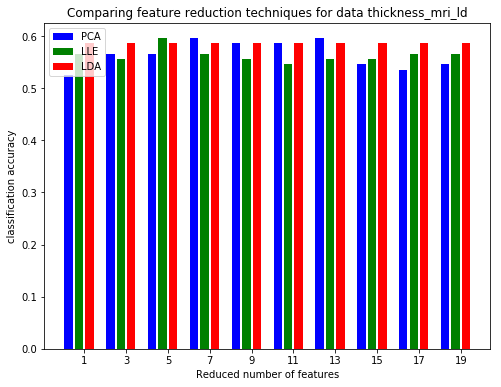

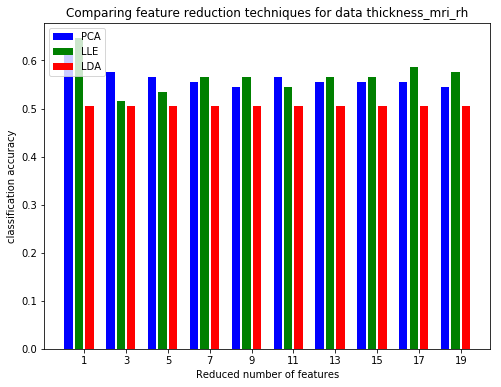

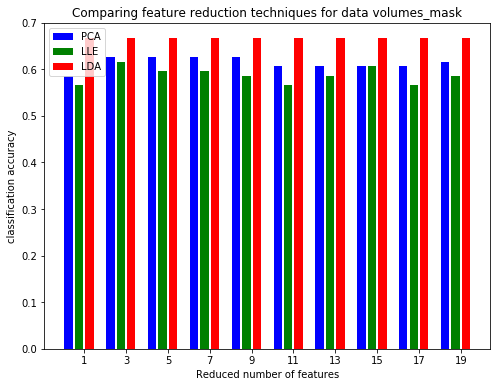

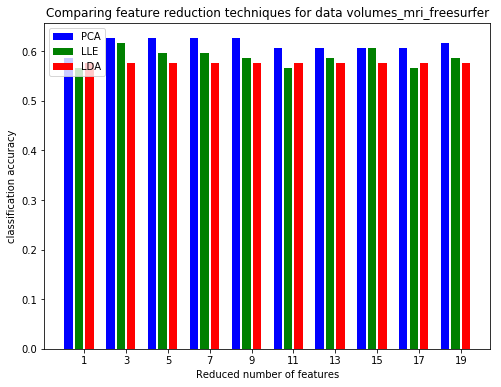

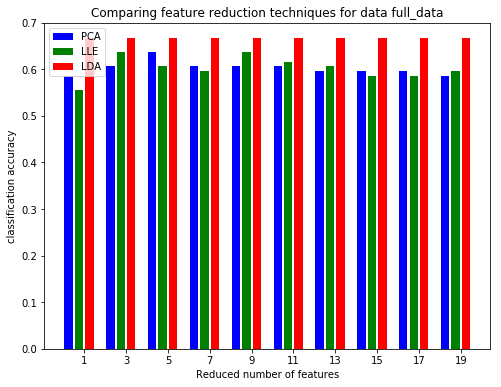

In [21]:
for i in range(len(data)):
    print(i)
    plot_comparing_feature_reduction(data[i], data_names[i], target_epilepsion)

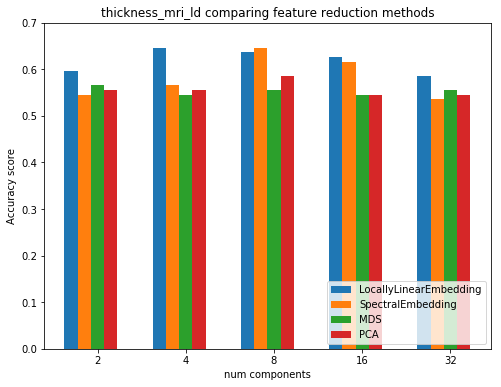

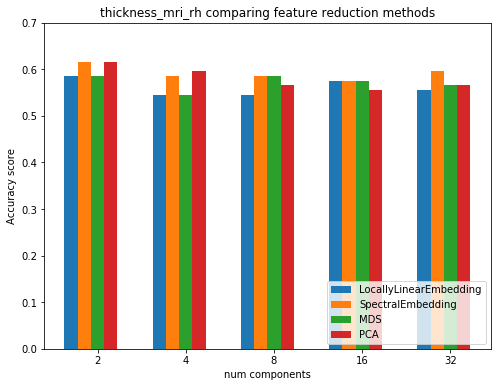

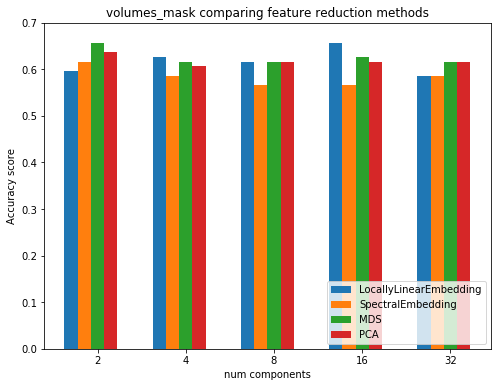

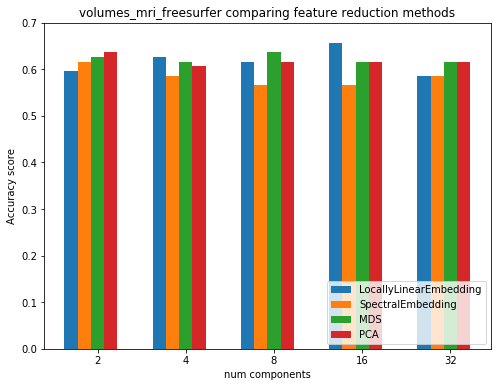

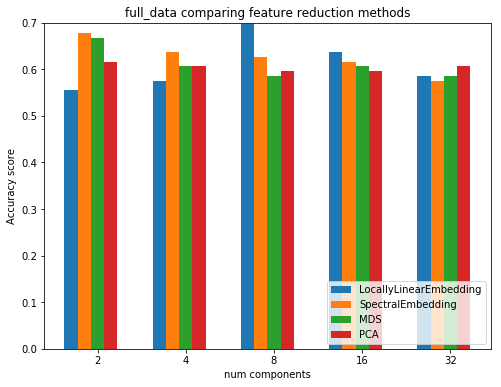

In [100]:
for i, d in enumerate(data):
    accuracy = calc_accuracy_for_data(d, methods, names_methods, n_comp_grid, target_epilepsion)
    
    plot_accuracy(accuracy, data_names[i] + " comparing feature reduction methods", names_methods, n_comp_grid)

Видим, что удалось улучшить качество.

Но оно все еще остается на довольно низком уровне.